# Лабораторная работа "Задача конвекции-диффузии"

In [266]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import math as m
import threading as thr
from ipywidgets import interact, widgets, interactive
import warnings
warnings.filterwarnings('ignore')

class GridFunction:
    def __init__(self, a, b, h, dim=1):
        self.dim = dim
        self.n = int((b - a) / h) + 1

        self.a = a
        self.b = a + h * (self.n - 1)
        self.h = h

        self.x = np.zeros(self.n)
        for i in range(self.n):
            self.x[i] = a + self.h * i

        if self.dim == 0:
            self.y = [[0]] * self.n
        elif self.dim == 1:
            self.y = np.zeros(self.n)
        else:
            np_list = []
            for i in range(self.n):
                np_list.append(np.zeros(self.dim))
            self.y = np.asarray(np_list)

    def calc(self, func, thread=False):
        self.f = func

        if thread:
            def thread_calc(i):
                self.y[i] = func(self.x[i])

            threads = [
                thr.Thread(target=thread_calc, args=(i,))
                for i in range(self.x.size)
            ]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()
        else:
            for i in range(self.x.size):
                self.y[i] = func(self.x[i])

    def calc_diff_eq(self, x0, dx, method):
        self.y[0] = x0
        method(self, dx)

    def plot(self, axes='01', marker='', label='', title_str='', figsize=(9, 6), new=True, ext_plt=None):
        if new and ext_plt is None:
            fig, self.ax = plt.subplots(figsize=figsize)
            self.ax.set(xlabel='x', ylabel='y', title=title_str)
            self.ax.grid()

        if ext_plt is not None:
            self.ax = ext_plt

        if self.dim == 0:
            x = []
            y = []
            for i in range(self.n):
                for j in range(len(self.y[i])):
                    x.append(self.x[i])
                    y.append(self.y[i][j])

            if label == '':
                self.ax.scatter(x, y, s=0.3)
            else:
                self.ax.scatter(x, y, s=0.3, label=label)
                self.ax.legend()
        else:
            x = self.x
            if axes[0] != '0':
                x = self.y
                if self.dim != 1:
                    x = np.split(self.y, self.dim, 1)[int(axes[0]) - 1]

            y = self.x
            if axes[1] != '0':
                y = self.y
                if self.dim != 1:
                    y = np.split(self.y, self.dim, 1)[int(axes[1]) - 1]

            if label == '':
                self.ax.plot(x, y, marker)
            else:
                self.ax.plot(x, y, marker, label = label)
                self.ax.legend()

def get_diff_coef(d, l, r): # f'(x_i) = sum k from -l to r (c_lr / h * f(x_i + k * h))
    n = l + r + 1
    A = np.zeros((n, n))
    f = np.zeros((n, 1))
    for i in range(n):
        for j in range(n):
            A[i][j] = (-l + j) ** i

    f[d] = 1 / m.factorial(d)
    return np.linalg.solve(A, f)

class LogError(GridFunction):
    def __init__(self, begin_h, end_h, step_h, true_x, dx):
        super().__init__(begin_h, end_h, step_h)
        self.dx = dx
        self.true_x = true_x

    def plot(self, title_str=''):
        super().plot(title_str = title_str)
        self.ax.set(xlabel='ln(h)', ylabel='ln(Err)')
        k, b = np.polyfit(self.x, self.y, 1)

        label_str = '{:.2f}*x + {:.2f}'.format(k, b)
        self.ax.plot(self.x, k * self.x + b, 'r-', linewidth=0.5, label=label_str)
        self.ax.legend()

    def calc(self, a, b, x0, method, logarithm=False, dim=1, get_sol=None):
        for i in range(self.n):
            def default_solution():
                gs = GridFunction(a, b, self.x[i], dim)
                gs.calc_diff_eq(x0, self.dx, method)
                return gs

            grid_sol = default_solution() if get_sol is None else get_sol(self.x[i], method)

            grid_true = GridFunction(a, b, self.x[i], dim)
            grid_true.calc(self.true_x)

            self.y[i] = np.amax(np.absolute(grid_sol.y - grid_true.y))

            if logarithm:
                self.x[i] = m.log(self.x[i])
                self.y[i] = m.log(self.y[i])

def tridiagonal(a, b, c, d):
    nf = len(d)
    for it in range(1, nf):
        mc = a[it] / b[it - 1]
        b[it] = b[it] - mc * c[it - 1]
        d[it] = d[it] - mc * d[it - 1]

    x = b
    x[-1] = d[-1] / b[-1]
    for il in range(nf - 2, -1, -1):
        x[il] = (d[il] - c[il] * x[il + 1]) / b[il]

    return x

def get_sol(a, b, h, k, v, f, div, cond, fract, mon=False):
    gf = GridFunction(a, b, h)
    pe = GridFunction(a, b, h)

    a_ = np.zeros(gf.n)
    b_ = np.zeros(gf.n)
    c_ = np.zeros(gf.n)
    d_ = np.zeros(gf.n)

    i = 1
    while i < gf.n - 1:
        h = gf.x[i + 1] - gf.x[i]
        xp = (gf.x[i] + gf.x[i + 1]) / 2
        xn = (gf.x[i] + gf.x[i - 1]) / 2
        pe.y[i] = h * abs(v(xp)) / k(xp)
        rho = 0

        if (pe.y[i] > 2) and fract:
            pe.y[i] = 1
            h = k(xp) * pe.y[i] / abs(v(xp))

            gf.x = np.insert(gf.x, i + 1, gf.x[i] + h)
            gf.y = np.insert(gf.y, i + 1, 0)
            pe.x = np.insert(pe.x, i + 1, gf.x[i] + h)
            pe.y = np.insert(pe.y, i + 1, 0)

            a_ = np.insert(a_, i + 1, 0)
            b_ = np.insert(b_, i + 1, 0)
            c_ = np.insert(c_, i + 1, 0)
            d_ = np.insert(d_, i + 1, 0)

            gf.n += 1
            pe.n += 1
            xp = (gf.x[i] + gf.x[i + 1]) / 2
            xn = (gf.x[i] + gf.x[i - 1]) / 2
        elif (pe.y[i] > 2) and mon:
            rho = pe.y[i] / 2

        vn = v(xn)
        vp = v(xp)
        kn = (1 + rho) * k(xn)
        kp = (1 + rho) * k(xp)

        if cond:
            if div:
                a_[i] = -(vn / 2 + kn / h) / h
                b_[i] = ((vp - vn) / 2 + (kp + kn) / h) / h
                c_[i] = -(-vp / 2 + kp / h) / h
                d_[i] = f(gf.x[i])
            else:
                a_[i] = -(vn / 2 + kn / h) / h
                b_[i] = ((vn - vp) / 2 + (kp + kn) / h) / h
                c_[i] = -(-vp / 2 + kp / h) / h
                d_[i] = f(gf.x[i])
        else:
            vpp = (v(xp) + abs(v(xp))) / 2
            vnp = (v(xp) - abs(v(xp))) / 2
            vpn = (v(xn) + abs(v(xn))) / 2
            vnn = (v(xn) - abs(v(xn))) / 2

            if div:
                a_[i] = -(vpn / 2 + k(xn) / h) / h
                b_[i] = ((vpp - vnn) / 2 + (k(xp) + k(xn)) / h) / h
                c_[i] = -(-vnp / 2 + k(xp) / h) / h
                d_[i] = f(gf.x[i])
            else:
                a_[i] = 0
                b_[i] = 0
                c_[i] = 0
                d_[i] = f(gf.x[i])

        i += 1

    b_[0] = 1
    b_[gf.n - 1] = 1

    gf.y = tridiagonal(a_, b_, c_, d_)
    return gf, pe

В качастве уравнения возьмем
$$
\begin{equation*}
    \begin{cases}
    -\frac{d}{dx}\left(x\frac{dy}{dx}\right)+\frac{d}{dx}\left(\frac{y}{x}\right)=x\\
    y(a)=y(5)=0 \\
    \end{cases}
\end{equation*}
$$
на отрезке $[0, 5]$. $\\$
Решение $y(x)=\frac{15}{2}e^{\frac{-1}{x}+\frac{1}{5}}-\frac{x^2}{4}-\frac{x}{4}$

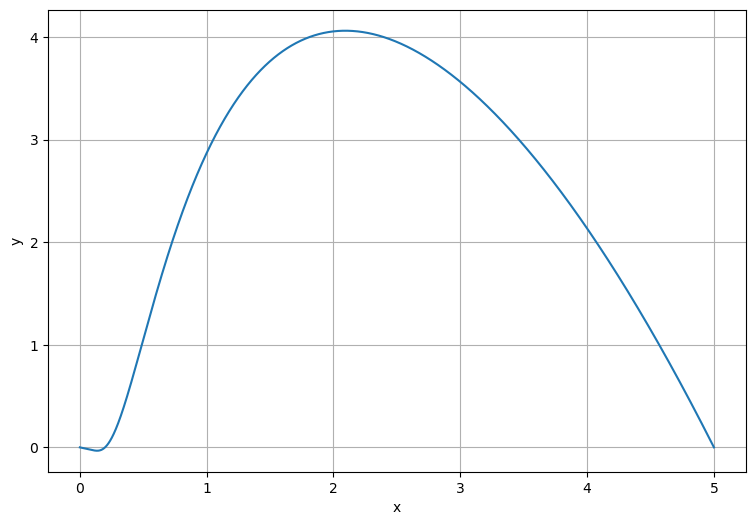

In [267]:
solut = lambda x: 15 / 2 * m.exp(-1 / x + 1 / 5) - x * x / 4 - x / 4
a = 0
b = 5
gf_sol = GridFunction(a, b, 0.001)
gf_sol.calc(solut)
gf_sol.plot()

k_x = lambda x: x
v_x = lambda x: 1 / x
f_x = lambda x: m.sin(4 * x) ** 2

## Условно монотонная схема

In [268]:
def draw_plot(h, fract):
    gf, pe = get_sol(a, b, h, k_x, v_x, f_x, div=True, cond=True, fract=fract)
    fig, axis = plt.subplots(2, 1, figsize=(10,5))
    axis[0].set(title='y(x)')
    axis[1].set(title='Pe(x)')
    axis[0].grid()
    axis[1].grid()
    gf.plot(ext_plt=axis[0])
    pe.plot(ext_plt=axis[1])

widg = interactive(draw_plot, h=widgets.FloatSlider(min=0.0001,max=0.1,step=0.0001,value=0.1), fract=widgets.ToggleButton(value=False))
widg

interactive(children=(FloatSlider(value=0.1, description='h', max=0.1, min=0.0001, step=0.0001), ToggleButton(…

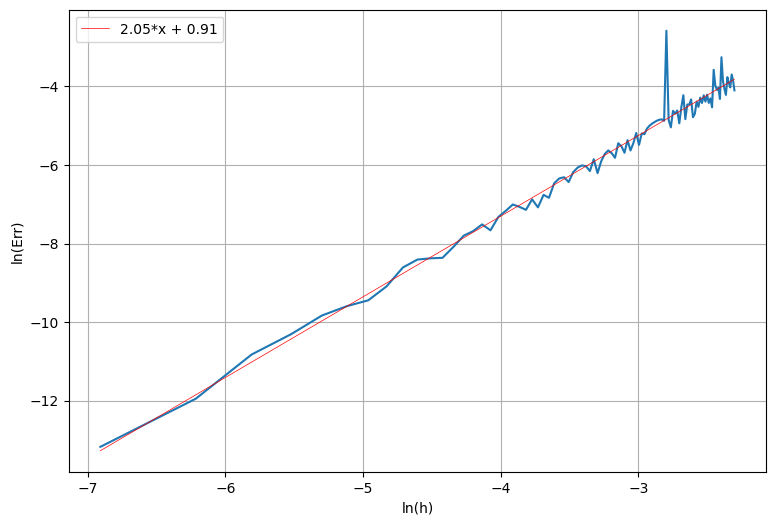

In [269]:
solut_ = lambda x: m.sin(x) ** 2
a_ = 0
b_ = m.pi

k_x_ = lambda x: (8 * x - m.sin(8 * x)) / (16 * m.sin(2 * x))
v_x_ = lambda x: (8 * x - m.sin(8 * x)) / (8 * m.sin(x) ** 2)
f_x_ = lambda x: m.sin(4 * x) ** 2

logerr = LogError(0.001, 0.1, 0.001, None, None)
for i in range(logerr.n):
    gf, pe = get_sol(a_, b_, logerr.x[i], k_x_, v_x_, f_x_, div=True, cond=True, fract=False)
    gt = copy.deepcopy(gf)
    gt.calc(solut)
    logerr.y[i] = -m.log(np.amax(np.absolute(gf.y - gt.y)))
    logerr.x[i] = m.log(logerr.x[i])
logerr.plot()


## Безусловно монотонная схема

In [270]:
def draw_plot(h, fract):
    gf, pe = get_sol(a, b, h, k_x, v_x, f_x, div=True, cond=False, fract=fract)
    fig, axis = plt.subplots(2, 1, figsize=(10,5))
    axis[0].set(title='y(x)')
    axis[1].set(title='Pe(x)')
    axis[0].grid()
    axis[1].grid()
    gf.plot(ext_plt=axis[0])
    pe.plot(ext_plt=axis[1])

widg = interactive(draw_plot, h=widgets.FloatSlider(min=0.0001,max=0.15,step=0.0001,value=0.1), fract=widgets.ToggleButton(value=False))
widg

interactive(children=(FloatSlider(value=0.1, description='h', max=0.15, min=0.0001, step=0.0001), ToggleButton…

## Монотонизированная схема

In [271]:
def draw_plot(h):
    gf, pe = get_sol(a, b, h, k_x, v_x, f_x, div=True, cond=True, fract=False, mon=True)
    gf.plot(figsize=(9,4))

widg = interactive(draw_plot, h=widgets.FloatSlider(min=0.0001,max=0.1,step=0.0001,value=0.1))
widg

interactive(children=(FloatSlider(value=0.1, description='h', max=0.1, min=0.0001, step=0.0001), Output()), _d…